# Import needed libraries
To make things work ensure that you have this libraries installed.

In [26]:
# imports
import os
import splitfolders
import tensorflow as tf
from typing import Tuple, List
from string import digits
from imutils import paths
from random import choices
from tensorflow.data import AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [23]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Data
The Dataset class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [29]:
class Dataset:
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, image_size: Tuple[int, int] = (224,224), batch_size: int = 8):
        self.path = path
        self.labels = [name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name))]

        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        if split:
            self.__split_folder()
        
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def generate(self) -> Tuple:
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        train_paths = list(paths.list_images(self.train))
        train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
        train_ds = (train_ds
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        val_paths = list(paths.list_images(self.val))
        val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
        val_ds = (val_ds
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        test_paths = list(paths.list_images(self.test))
        test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
        test_ds = (test_ds
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        return train_ds, val_ds, test_ds

# Xception
The *build_model* method is used to build model based on [Xception network](https://arxiv.org/abs/1610.02357) with added custom dense layers. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [84]:
def build_model(height: int = 224, width: int = 224, channels: int = 3):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    model.add(tf.keras.applications.Xception(include_top=False,
                                           weights=None,
                                           input_shape=input_shape,
                                           pooling='max'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

# Short-Time Fourier Transform

In [85]:
model = build_model()

In [ ]:
batch_size = 16
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.generate()

In [86]:
epochs = 75
batch_size = 8

# Train the model using generator for training data and validation data
history = model.fit(train_stft,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=len(train_stft) // batch_size,
                    validation_data=val_stft,
                    validation_steps=len(val_stft) // batch_size,
                    verbose=1)

Epoch 1/75


W0000 00:00:1712602519.087076     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.1684 - loss: 2.3828

W0000 00:00:1712602527.637068     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - accuracy: 0.1695 - loss: 2.3778 - val_accuracy: 0.0750 - val_loss: 2.3027
Epoch 2/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.2572 - loss: 1.9908 - val_accuracy: 0.1750 - val_loss: 2.3026
Epoch 3/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.3713 - loss: 1.7790 - val_accuracy: 0.1250 - val_loss: 2.3032
Epoch 4/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.3871 - loss: 1.6738 - val_accuracy: 0.0750 - val_loss: 2.3000
Epoch 5/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.5631 - loss: 1.3246 - val_accuracy: 0.1250 - val_loss: 2.3022
Epoch 6/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.5268 - loss: 1.3608 - val_accuracy: 0.0750 - val_loss: 2.3089
Epoch 7/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.5222 - loss: 1.2117 - val_accuracy: 0.0875 - val_loss: 2.3044
Epoch 8/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.5578 - loss: 1.2897 - val_accuracy: 0.1000 - val

W0000 00:00:1712602583.995481     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.6053 - loss: 1.2303 - val_accuracy: 0.1500 - val_loss: 2.2989
Epoch 10/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.6595 - loss: 1.0247 - val_accuracy: 0.1034 - val_loss: 2.2918
Epoch 11/75


W0000 00:00:1712602591.621532     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.6864 - loss: 0.9047 - val_accuracy: 0.0750 - val_loss: 2.3050
Epoch 12/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7733 - loss: 0.7212 - val_accuracy: 0.0875 - val_loss: 2.3160
Epoch 13/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.8062 - loss: 0.6551 - val_accuracy: 0.1250 - val_loss: 2.3011
Epoch 14/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.8940 - loss: 0.4255 - val_accuracy: 0.0750 - val_loss: 2.2866
Epoch 15/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.9219 - loss: 0.3481 - val_accuracy: 0.1250 - val_loss: 2.3001
Epoch 16/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.9671 - loss: 0.2724 - val_accuracy: 0.0750 - val_loss: 2.3728
Epoch 17/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9176 - loss: 0.3689 - val_accuracy: 0.0875 - val_loss: 2.3833
Epoch 18/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9491 - loss: 0.2121 - val_accuracy: 0.1000 

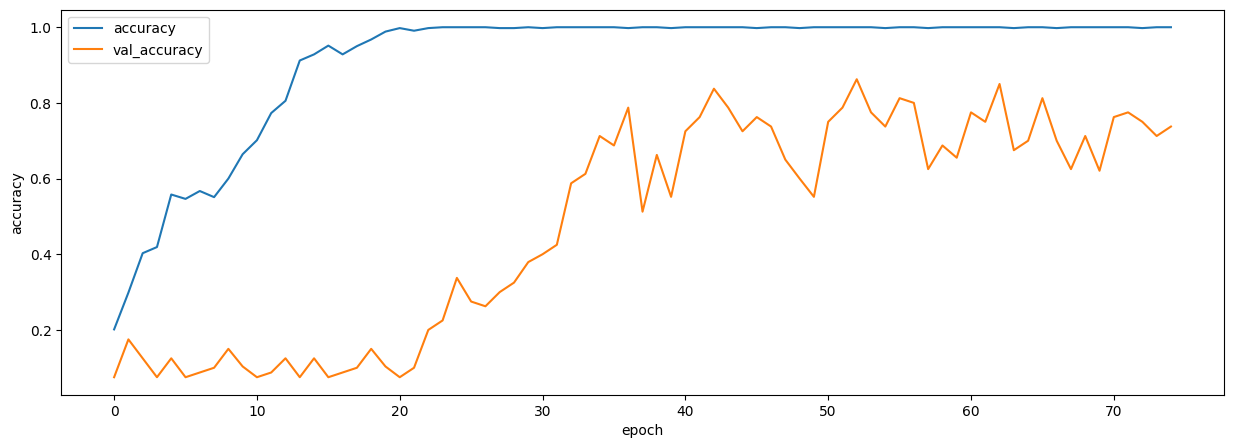

In [87]:
plot_history(history, metric='accuracy')

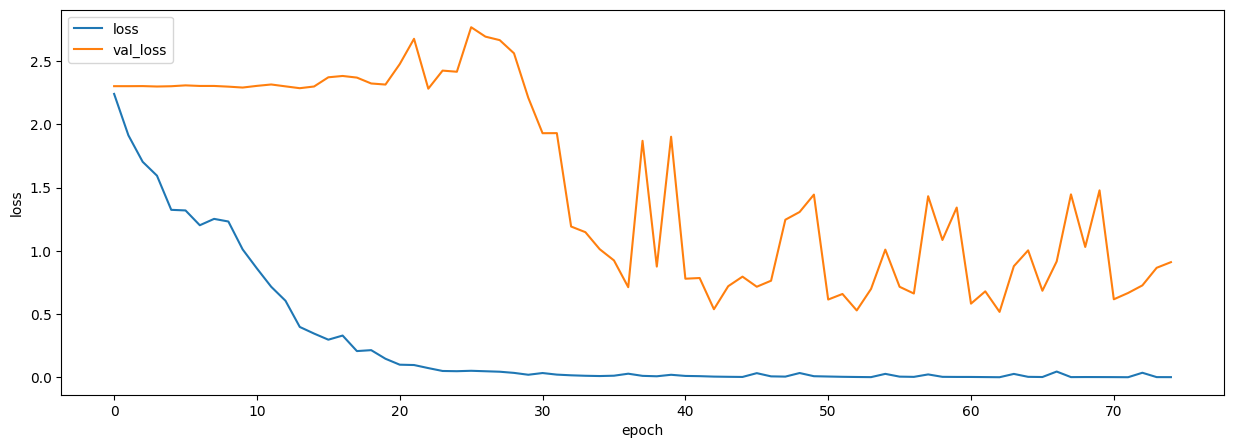

In [88]:
plot_history(history, metric='loss')

In [89]:
evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7112 - loss: 0.8586
Accuracy: 0.7319999933242798
Loss: 0.8516407608985901


W0000 00:00:1712602968.946818      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 4/47 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

W0000 00:00:1712602993.881575     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step


W0000 00:00:1712602998.946314      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


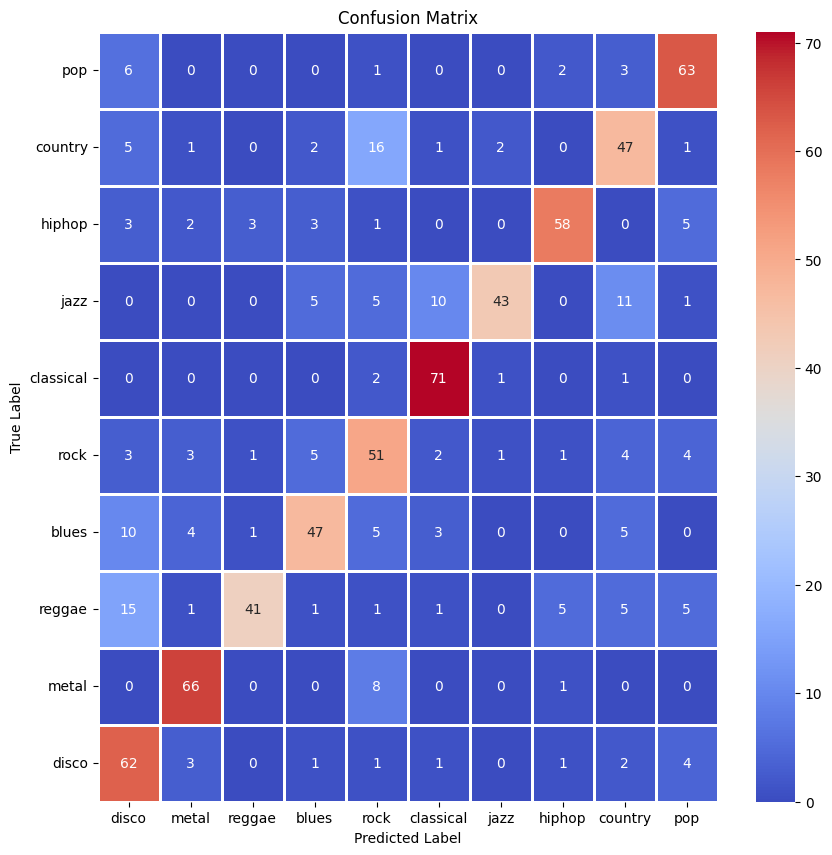

              precision    recall  f1-score   support

           0       0.60      0.83      0.69        75
           1       0.82      0.88      0.85        75
           2       0.89      0.55      0.68        75
           3       0.73      0.63      0.68        75
           4       0.56      0.68      0.61        75
           5       0.80      0.95      0.87        75
           6       0.91      0.57      0.70        75
           7       0.85      0.77      0.81        75
           8       0.60      0.63      0.61        75
           9       0.76      0.84      0.80        75

    accuracy                           0.73       750
   macro avg       0.75      0.73      0.73       750
weighted avg       0.75      0.73      0.73       750



In [90]:
y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel Spectogram

In [91]:
batch_size = 8
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.generate()

Copying files: 4995 files [00:37, 133.95 files/s]


In [92]:
model = build_model()

epochs = 75
batch_size = 8

# Train the model using generator for training data and validation data
history = model.fit(train_stft,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=len(train_stft) // batch_size,
                    validation_data=val_stft,
                    validation_steps=len(val_stft) // batch_size,
                    verbose=1)

Epoch 1/75
 1/54 ━━━━━━━━━━━━━━━━━━━━ 30:40 35s/step - accuracy: 0.1250 - loss: 3.2071

W0000 00:00:1712603551.734154      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1903 - loss: 2.4582

W0000 00:00:1712603561.098421     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 181ms/step - accuracy: 0.1907 - loss: 2.4540 - val_accuracy: 0.1023 - val_loss: 2.3030
Epoch 2/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.3302 - loss: 1.8871 - val_accuracy: 0.0795 - val_loss: 2.3062
Epoch 3/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.3696 - loss: 1.7435 - val_accuracy: 0.1136 - val_loss: 2.3009
Epoch 4/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.3715 - loss: 1.7697 - val_accuracy: 0.0682 - val_loss: 2.3069
Epoch 5/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.4024 - loss: 1.5342 - val_accuracy: 0.0909 - val_loss: 2.2931
Epoch 6/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.3934 - loss: 1.5628 - val_accuracy: 0.0795 - val_loss: 2.3070
Epoch 7/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.5055 - loss: 1.4346 - val_accuracy: 0.1136 - val_loss: 2.3039
Epoch 8/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.5085 - loss: 1.3392 - val_accuracy: 0.1250 - val

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5571 - loss: 1.4104 - val_accuracy: 0.1556 - val_loss: 2.3028
Epoch 10/75
 1/54 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8750 - loss: 0.7527

W0000 00:00:1712603612.669916      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6118 - loss: 1.1690 - val_accuracy: 0.1023 - val_loss: 2.3576
Epoch 11/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6083 - loss: 1.1504 - val_accuracy: 0.1023 - val_loss: 2.4628
Epoch 12/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.5551 - loss: 1.2218 - val_accuracy: 0.2159 - val_loss: 2.2814
Epoch 13/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.6012 - loss: 1.1219 - val_accuracy: 0.3295 - val_loss: 2.0242
Epoch 14/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.6990 - loss: 0.9241 - val_accuracy: 0.2727 - val_loss: 2.1244
Epoch 15/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6656 - loss: 0.8968 - val_accuracy: 0.3750 - val_loss: 1.7414
Epoch 16/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7163 - loss: 0.8220 - val_accuracy: 0.5682 - val_loss: 1.1438
Epoch 17/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7578 - loss: 0.7364 - val_accuracy: 0.4318

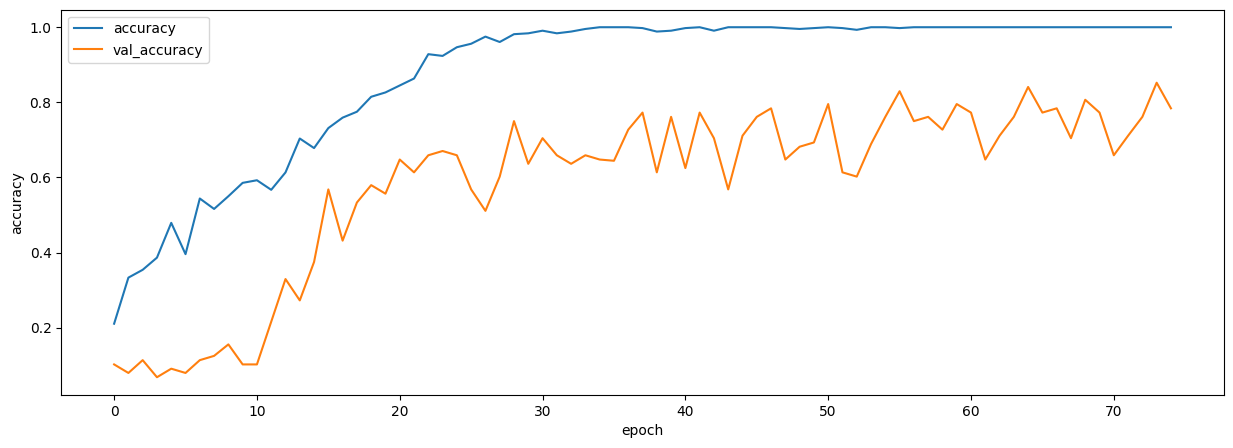

In [93]:
plot_history(history, metric='accuracy')

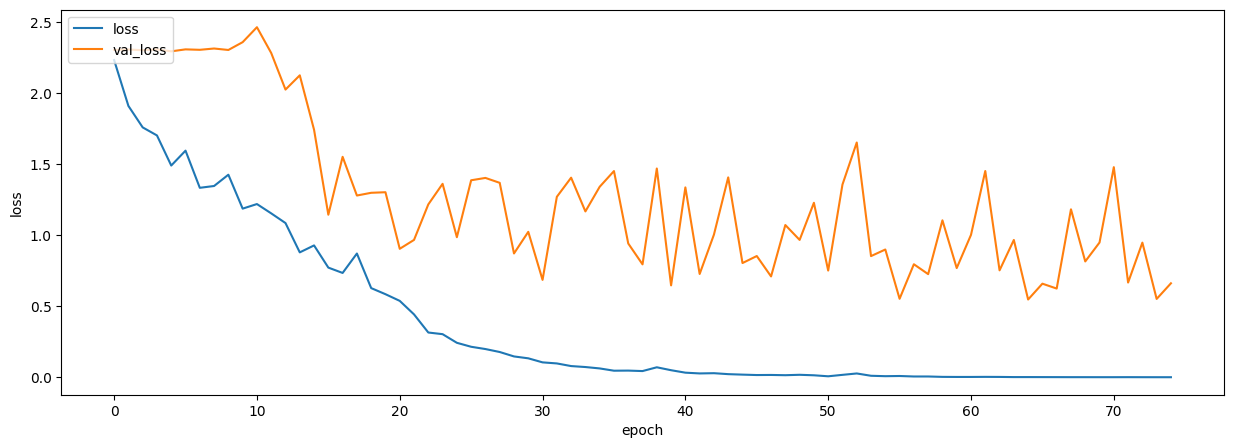

In [94]:
plot_history(history, metric='loss')

In [95]:
evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7819 - loss: 0.7530
Accuracy: 0.7879999876022339
Loss: 0.7028927803039551


W0000 00:00:1712604048.238345     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

W0000 00:00:1712604071.139922      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step


W0000 00:00:1712604076.693092     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


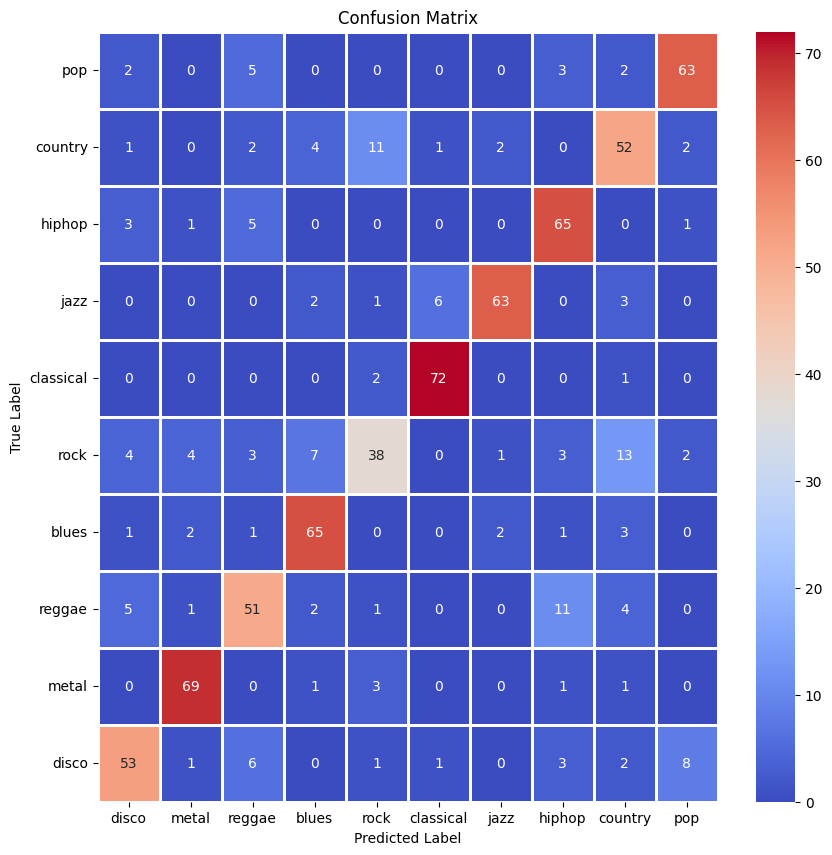

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        75
           1       0.88      0.92      0.90        75
           2       0.70      0.68      0.69        75
           3       0.80      0.87      0.83        75
           4       0.67      0.51      0.58        75
           5       0.90      0.96      0.93        75
           6       0.93      0.84      0.88        75
           7       0.75      0.87      0.80        75
           8       0.64      0.69      0.67        75
           9       0.83      0.84      0.83        75

    accuracy                           0.79       750
   macro avg       0.79      0.79      0.79       750
weighted avg       0.79      0.79      0.79       750



In [96]:
y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))